In [1]:
def __return_waypoints_ind():
    d = np.array([
    [ 65, -36],
    [ 56, -21],
    [ 66, -46],
    [ 58, -48],
    [ 67, -29],
    [ 61, -16],
    [ 45, -32],
    [ 71, -43],
    # [ 80, -52],
    # [ 68, -58],
    [ 65, -54],
    [ 48, -20],
    [ 64, -21],
    [ 46, -14]])
    return d

%load_ext autoreload
%autoreload 2


In [2]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)


''' create the graph instance '''    
interest_points = __return_waypoints_ind()
g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

df_signals = scene_data.df_to_lst_realxy_mats()
g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
g.recalculate_trans_mat_dependencies()

In [3]:
# Get the locations of the points where the example path will go
print(g.destination_locations[3])
print(g.waypoint_vals[8])
print(g.waypoint_vals[3])
print(g.waypoint_vals[6])
print(g.waypoint_vals[9])
print(g.waypoint_vals[11])
print(g.destination_locations[7])


(70.0, -61.0)
(65, -54)
(58, -48)
(45, -32)
(48, -20)
(46, -14)
(36.0, -3.0)


In [4]:
# Get the generated path
df = scene_data.traj_dataframe
df_grouped = df[['agent_id', 'pos_x']].groupby(['agent_id']).agg(['count'])
df_grouped=df_grouped["pos_x"]
df_grouped.sort_values(by='count', ascending=False).head(15)
route = df[df['agent_id']==2409][["pos_x", "pos_y"]].to_numpy()

0.1298885335726091
0.014885518399626202
0.00020064337350022906
0.00020064337350022906
1.570170295660561e-06


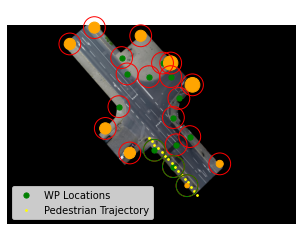

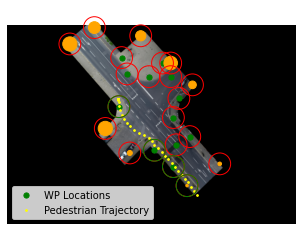

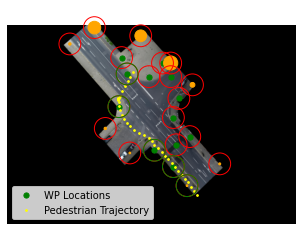

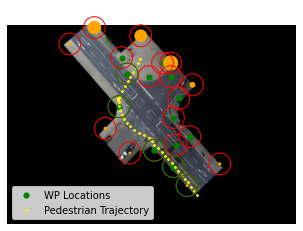

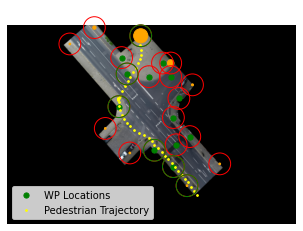

In [34]:
slice_list = [16, 40, 50, 53, 58]

i = 0
for slice in slice_list:    
    fig, ax = plt.subplots()
    current_route = route[:slice]
    stupid_dict = dict(zip(["x", "y"], [0, 1]))
    scene_data.plot_on_image([np.array(g.waypoint_vals), current_route], colors=['green', 'yellow'], 
    ax=ax, col_num_dicts=[stupid_dict,stupid_dict], ms=[27,3], labels=["WP Locations", "Pedestrian Trajectory"], hide_axes=True)
    triggered_wps, triggered_wp_locs = g.analyse_full_signal(current_route, False)
    dest_probs = g.calculate_destination_probs(triggered_wps)
    scene_data.plot_dest_probs(g.destination_locations, list(dest_probs.values()), 3, 200, ax=ax, color='orange')
    scene_data.add_circles(g.points_locations, GRAPH_DIST_THRESH, ax=ax, color='red')
    # ax.set_title("Destination predictions for an example\npath from the inD data set")
    scene_data.add_circles(triggered_wp_locs, GRAPH_DIST_THRESH, ax=ax, color='green', save_path='data/images/example_traject/example_path_'+str(i)+'.png')
    
    i += 1
    
# 2876, 2409

In [ ]:
len(np.array(g.destination_locations))

9

In [ ]:
# Plot generated path on background and display destination probs